**IMPORTA AS BIBLIOTECAS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

**LEITURA DOS ARQUIVOS**

In [2]:
class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x

path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

# Estrutura de dados
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados

**SOLUÇÃO INICIAL**

In [3]:
def Sol_Inicial(dados):
    n = dados.n
    delta_t = 5
    planos_ids = [1, 2, 3]

    k_fatores = dados.planos['k'].to_dict()
    custo_beneficio = np.zeros(n)

    for i in range(n):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq['cluster']]
        eta = cluster['eta']
        beta = cluster['beta']
        custo_falha = eq['custo de falha']

        t0 = eq['t0']
        Fi = lambda t: 1 - np.exp(- (t / eta)**beta)
        pi = (Fi(t0 + k_fatores[1] * delta_t) - Fi(t0)) / (1 - Fi(t0))

        custo_manut = dados.planos.loc[1, 'custo']

        custo_beneficio[i] = (pi * custo_falha) / custo_manut

    indices_ordenados = np.argsort(custo_beneficio)

    sol_inicial = np.zeros(n, dtype=int)
    corte1 = n // 3
    corte2 = 2 * (n // 3)

    sol_inicial[indices_ordenados[:corte1]] = 1
    sol_inicial[indices_ordenados[corte1:corte2]] = 2
    sol_inicial[indices_ordenados[corte2:]] = 3

    return sol_inicial

def imprime_solucao_inicial(solucao):
    print("Solução Inicial: planos de manutenção por equipamento")
    print("Equipamento | Plano de Manutenção")
    print("-------------------------------")
    for i, plano in enumerate(solucao, start=1):
        print(f"{i:10d} | {plano:18d}")
        
# dados = manutencao_def(Equipamentos, Planos)
# sol_ini = Sol_Inicial(dados)
# imprime_solucao_inicial(sol_ini)


In [4]:
# def Sol_Inicial(dados):
#     n = dados.n
#     # Define vetor com plano 1 para todos equipamentos
#     sol_inicial = np.ones(n, dtype=int)
#     return sol_inicial

**FUNÇÕES OBJETIVO**

In [5]:
def fobj_f1(x, dados):
    custo_total = sum(dados.custo_por_plano[plano] for plano in x.solution)
    x.fitness = custo_total
    return x

def fobj_f2(x, dados):
    custo = 0
    for i, plano in enumerate(x.solution):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq["cluster"]]
        plano_info = dados.planos.loc[plano]

        t0 = eq["t0"]
        k = plano_info["k"]
        delta_t = 5
        eta = cluster["eta"]
        beta = cluster["beta"]

        Fi = lambda t: 1 - np.exp(-(t / eta)**beta)
        pi = (Fi(t0 + k * delta_t) - Fi(t0)) / (1 - Fi(t0))
        custo += pi * eq["custo de falha"]

    x.fitness = custo
    return x

**GVNS - Busca Local**

In [6]:
def busca_local_gvns(solucao, vizinhancas, fobj, dados, max_avaliacoes, r):
    x = copy.deepcopy(solucao)
    avaliacoes = 0
    melhorou = True

    while melhorou and avaliacoes < max_avaliacoes:
        melhorou = False
        for viz in vizinhancas:
            y = viz(x, r)
            y = fobj(y, dados)
            avaliacoes += 1
            if y.fitness < x.fitness:
                x = copy.deepcopy(y)
                melhorou = True
                break
    return x, avaliacoes

**GVNS**

In [7]:
def gvns(sol_inicial, fobj, max_iter, k_max, vizinhancas, dados, r=10):
    x = wrap_struct(sol_inicial())
    x = fobj(x, dados)
    melhor = copy.deepcopy(x)
    num_avaliadas = 1
    historico = [melhor.fitness]

    while num_avaliadas < max_iter:
        k = 0
        while k < k_max and num_avaliadas < max_iter:
            # Shaking - perturba solução atual na vizinhança k
            y = vizinhancas[k](x, r)
            y = fobj(y, dados)
            num_avaliadas += 1

            # Busca local a partir de y
            y_local, avals = busca_local_gvns(y, vizinhancas, fobj, dados, max_iter - num_avaliadas, r)
            num_avaliadas += avals
            y = y_local

            # Critério de aceitação simples: se melhor, aceita
            if y.fitness < melhor.fitness:
                melhor = copy.deepcopy(y)
                x = copy.deepcopy(y)
                k = 0  # volta para menor vizinhança
            else:
                k += 1

            historico.append(melhor.fitness)

    return melhor, historico

**GVNS - Operadores de Vizinhança**

In [8]:
def shake(x, r, planos=3):
    """
    Troca o plano de manutenção de r equipamentos aleatórios para outro plano diferente.
    """
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        opcoes = [p for p in range(1, planos+1) if p != y.solution[idx]]
        y.solution[idx] = np.random.choice(opcoes)
    return y

def shake_adiciona(x, r, planos=3):
    """
    Incrementa o plano de manutenção em r equipamentos (se não estiver no máximo).
    """
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        if y.solution[idx] < planos:
            y.solution[idx] += 1
    return y

def shake_subtrai(x, r):
    """
    Decrementa o plano de manutenção em r equipamentos (se não estiver no mínimo).
    """
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        if y.solution[idx] > 1:
            y.solution[idx] -= 1
    return y


**RVNS**

In [9]:

# # Operadores de vizinhança
# def shake(x, r, planos=3):
#     y = copy.deepcopy(x)
#     indices = np.random.permutation(len(x.solution))[:r]
#     for idx in indices:
#         plano_atual = y.solution[idx]
#         opcoes = [p for p in range(1, planos+1) if p != plano_atual]
#         y.solution[idx] = np.random.choice(opcoes)
#     return y

# def shake_adiciona(x, r):
#     y = copy.deepcopy(x)
#     indices = np.random.permutation(len(y.solution))[:r]
#     for idx in indices:
#         if y.solution[idx] < 3:
#             y.solution[idx] += 1
#     return y

# def shake_subtrai(x, r):
#     y = copy.deepcopy(x)
#     indices = np.random.permutation(len(y.solution))[:r]
#     for idx in indices:
#         if y.solution[idx] > 1:
#             y.solution[idx] -= 1
#     return y

# # Algoritmo RVNS otimizado
# def rvns_otimizado(fobj, sol_inicial, shake, max_num_sol_avaliadas, r=10, kmax=3):
#     x = wrap_struct(sol_inicial())
#     x = fobj(x)
    
#     num_sol_avaliadas = 1
#     historico = [x.fitness]
#     best = copy.deepcopy(x)
#     historico_best = [best.fitness]

#     estruturas_vizinhanca = [shake_adiciona, shake_subtrai, shake]

#     while num_sol_avaliadas < max_num_sol_avaliadas:
#         k = 1
#         while k <= kmax and num_sol_avaliadas < max_num_sol_avaliadas:
#             for shake_func in estruturas_vizinhanca:
#                 if num_sol_avaliadas >= max_num_sol_avaliadas:
#                     break
                    
#                 y = shake_func(x, r)
#                 y = fobj(y)
#                 num_sol_avaliadas += 1
#                 historico.append(x.fitness)
                
#                 if y.fitness < best.fitness:
#                     best = copy.deepcopy(y)
#                 historico_best.append(best.fitness)

#                 if y.fitness < x.fitness:
#                     x = copy.deepcopy(y)
#                     break
#             else:
#                 k += 1

#     return best, historico

**FUNÇÃO SOMA PONDERADA**

In [10]:
def soma_ponderada(x, dados, peso_f1):
    peso_f2 = 100 - peso_f1
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    # Normalização (ajuste os valores de referência conforme necessário)
    ref_f1 = 1048.18  # Referência para f1 (custo total de manutenção)
    ref_f2 = 1744  # Referência para f2 (custo total de falha)
    
    f1_norm = f1 / ref_f1
    f2_norm = f2 / ref_f2
    
    x.fitness = (f1_norm * peso_f1 + f2_norm * peso_f2) / 100
    return x

**FUNÇÃO EPSILON RESTRITO**

In [11]:
def fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal='f1'):
    """
    Função objetivo ϵ-restrito aprimorada.
    
    Args:
        x: Solução candidata
        dados: Dados do problema
        epsilon: Valor limite para a função objetivo restrita
        objetivo_principal: Qual função será otimizada ('f1' ou 'f2')
    
    Returns:
        x com fitness calculado (com penalização adaptativa se violar a restrição)
    """
    # Calcula ambos os objetivos uma única vez
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    if objetivo_principal == 'f1':
        # Minimiza f1 sujeito a f2 <= epsilon
        if f2 <= epsilon:
            x.fitness = f1
        else:
            # Penalização adaptativa proporcional à violação
            violacao = f2 - epsilon
            x.fitness = f1 + 1e6 * violacao  # Fator grande para garantir dominância
    else:
        # Minimiza f2 sujeito a f1 <= epsilon
        if f1 <= epsilon:
            x.fitness = f2
        else:
            violacao = f1 - epsilon
            x.fitness = f2 + 1e6 * violacao
    
    return x



**FRONTEIRA PARETO - Epsilon Restrito**

In [12]:
def gerar_fronteira_epsilon(dados, num_pontos=20, max_iteracoes=100, objetivo_principal='f1'):
    print("Calculando soluções extremas para determinar faixa de epsilon...")

    extremos_cache = {}

    def calcular_extremos():
        if not extremos_cache:
            best_f1, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=lambda x, dados=dados: fobj_f1(x, dados),
                max_iter=max_iteracoes,
                k_max=3,
                vizinhancas=[shake_adiciona, shake_subtrai, shake],
                dados=dados,
                r=10
            )
            best_f2, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=lambda x, dados=dados: fobj_f2(x, dados),
                max_iter=max_iteracoes,
                k_max=3,
                vizinhancas=[shake_adiciona, shake_subtrai, shake],
                dados=dados,
                r=10
            )

            extremos_cache.update({
                'min_f1': best_f1.fitness,
                'max_f2': fobj_f2(copy.deepcopy(best_f1), dados).fitness,
                'max_f1': fobj_f1(copy.deepcopy(best_f2), dados).fitness,
                'min_f2': best_f2.fitness
            })
        return extremos_cache

    extremos = calcular_extremos()

    if objetivo_principal == 'f1':
        epsilons = np.logspace(np.log10(extremos['min_f2']),
                              np.log10(extremos['max_f2']),
                              num_pontos)
    else:
        epsilons = np.logspace(np.log10(extremos['min_f1']),
                              np.log10(extremos['max_f1']),
                              num_pontos)

    resultados_f1 = []
    resultados_f2 = []
    solucoes_validas = 0

    for eps in epsilons:
        print(f"\nOtimizando com epsilon = {eps:.2f} (Progresso: {len(resultados_f1)+1}/{num_pontos})")

        fobj = lambda x, dados=dados, epsilon=eps: fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal)

        best, _ = gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iteracoes,
            k_max=3,
            vizinhancas=[shake_adiciona, shake_subtrai, shake],
            dados=dados,
            r=max(5, int(len(dados.equipamentos) * 0.02))
        )

        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness

        if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps):
            solucoes_validas += 1
            resultados_f1.append(f1)
            resultados_f2.append(f2)
        else:
            print(f"Solução inválida encontrada para eps={eps:.2f} - descartando")

    print(f"\nEstatísticas:")
    print(f"- Total de pontos tentados: {num_pontos}")
    print(f"- Soluções válidas encontradas: {solucoes_validas} ({solucoes_validas/num_pontos:.1%})")

    return resultados_f1, resultados_f2

**FRONTEIRA PARETO - Soma Ponderada**

In [ ]:
def gerar_matriz_pontos(resultados_f1, resultados_f2):
    """
    Gera uma matriz detalhada com todos os pontos encontrados e indica quais são dominados.
    
    Args:
        resultados_f1: Lista de valores de custo de manutenção (F1)
        resultados_f2: Lista de valores de custo     de falha (F2)
    
    Returns:
        DataFrame com colunas: [Índice, F1, F2, É_Dominado, Dominado_Por]
    """
    pontos = list(zip(resultados_f1, resultados_f2))
    n = len(pontos)
    
    # Cria estrutura para armazenar informações
    dados_matriz = {
        'Índice': [],
        'F1': [],
        'F2': [],
        'É_Dominado': [],
        'Dominado_Por': []
    }
    
    # Preenche a matriz
    for i, (f1, f2) in enumerate(pontos):
        dominado = False
        dominadores = []
        
        for j, (f1_comp, f2_comp) in enumerate(pontos):
            if i == j:
                continue
                
            # Verifica se é dominado
            if (f1_comp <= f1) and (f2_comp <= f2) and ((f1_comp < f1) or (f2_comp < f2)):
                dominado = True
                dominadores.append(j)
        
        dados_matriz['Índice'].append(i)
        dados_matriz['F1'].append(f1)
        dados_matriz['F2'].append(f2)
        dados_matriz['É_Dominado'].append(dominado)
        dados_matriz['Dominado_Por'].append(dominadores if dominadores else None)
    
    # Cria DataFrame
    df = pd.DataFrame(dados_matriz)
    
    # Adiciona coluna de status Pareto
    df['Status_Pareto'] = df['É_Dominado'].apply(lambda x: 'Não-Dominado' if not x else 'Dominado')
    
    return df

In [ ]:
def gerar_fronteira_soma(dados, num_pontos=20, max_iteracoes=100):
    pesos = np.linspace(0, 100, num_pontos)
    resultados_f1 = []
    resultados_f2 = []

    for peso in pesos:
        print(f"Otimizando para peso f1 = {peso:.1f}, f2 = {100 - peso:.1f}")

        fobj = lambda x, dados=dados, peso=peso: soma_ponderada(x, dados, peso)

        best, _ = gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iteracoes,
            k_max=3,
            vizinhancas=[shake_adiciona, shake_subtrai, shake],
            dados=dados,
            r=10
        )

        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness

        resultados_f1.append(f1)
        resultados_f2.append(f2)
    # Gera a matriz de pontos
    matriz_pontos = gerar_matriz_pontos(resultados_f1, resultados_f2)
        # Exibe os resultados
    print("\n=== MATRIZ COMPLETA DE PONTOS ===")
    print(matriz_pontos)
    
    # Filtra apenas pontos não-dominados
    fronteira_pareto = matriz_pontos[matriz_pontos['Status_Pareto'] == 'Não-Dominado']
    print("\n=== FRONTEIRA DE PARETO ===")
    print(fronteira_pareto[['Índice', 'F1', 'F2']])

    return resultados_f1, resultados_f2

**CONFERE SE O PONTO ENCONTRADO É DOMINADO POR ALGUM OUTRO**

**GERA GRÁFICO DE RESULTADOS**


Gerando fronteira com ϵ-restrito (min F1)...
Calculando soluções extremas para determinar faixa de epsilon...


C:\Users\Pichau\AppData\Local\Temp\ipykernel_88900\1370561199.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  custo_beneficio[i] = (pi * custo_falha) / custo_manut



Otimizando com epsilon = 1150.74 (Progresso: 1/20)

Otimizando com epsilon = 1170.20 (Progresso: 2/20)

Otimizando com epsilon = 1189.98 (Progresso: 3/20)

Otimizando com epsilon = 1210.10 (Progresso: 4/20)

Otimizando com epsilon = 1230.56 (Progresso: 5/20)

Otimizando com epsilon = 1251.36 (Progresso: 6/20)

Otimizando com epsilon = 1272.52 (Progresso: 7/20)

Otimizando com epsilon = 1294.03 (Progresso: 8/20)

Otimizando com epsilon = 1315.90 (Progresso: 9/20)

Otimizando com epsilon = 1338.15 (Progresso: 10/20)

Otimizando com epsilon = 1360.77 (Progresso: 11/20)

Otimizando com epsilon = 1383.78 (Progresso: 12/20)

Otimizando com epsilon = 1407.17 (Progresso: 13/20)

Otimizando com epsilon = 1430.96 (Progresso: 14/20)

Otimizando com epsilon = 1455.15 (Progresso: 15/20)

Otimizando com epsilon = 1479.75 (Progresso: 16/20)

Otimizando com epsilon = 1504.77 (Progresso: 17/20)

Otimizando com epsilon = 1530.21 (Progresso: 18/20)

Otimizando com epsilon = 1556.08 (Progresso: 19/20)

O

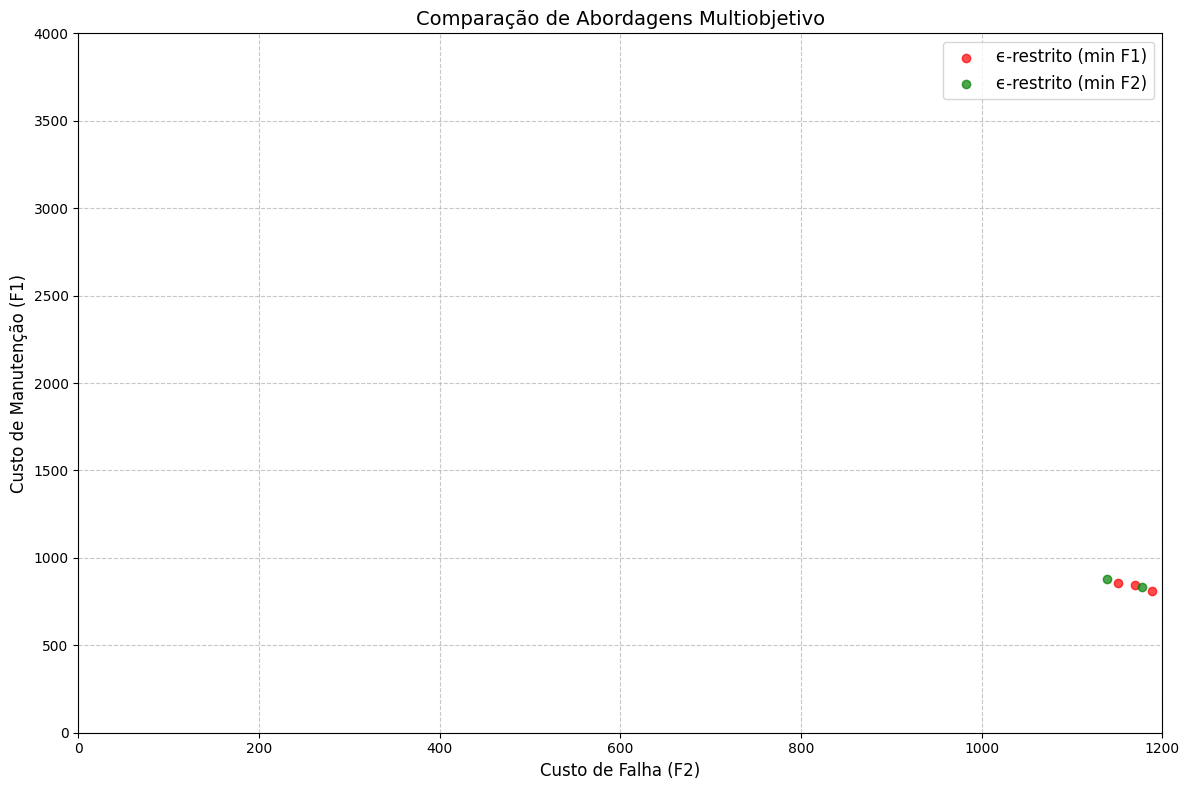

In [14]:
# Função para plotar resultados comparativos
def plotar_resultados_comparativos(dados, num_pontos=20, max_iteracoes=100):
    # Gerar fronteiras com diferentes abordagens
    # print("\nGerando fronteira com Soma Ponderada...")
    #f1_pw, f2_pw = gerar_fronteira_pareto(dados, num_pontos, max_iteracoes)
    
    print("\nGerando fronteira com ϵ-restrito (min F1)...")
    f1_eps1, f2_eps1 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f1')
    
    print("\nGerando fronteira com ϵ-restrito (min F2)...")
    f1_eps2, f2_eps2 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f2')
    
    # Plot comparativo
    plt.figure(figsize=(12, 8))
    
    # Soma ponderada
    # plt.scatter(f2_pw, f1_pw, c='blue', marker='o', label='Soma Ponderada', alpha=0.7)
    
    # ϵ-restrito (min f1)
    plt.scatter(f2_eps1, f1_eps1, c='red', marker='o', label='ϵ-restrito (min F1)', alpha=0.7)
    
    # ϵ-restrito (min f2)
    plt.scatter(f2_eps2, f1_eps2, c='green', marker='o', label='ϵ-restrito (min F2)', alpha=0.7)
    
    plt.title("Comparação de Abordagens Multiobjetivo", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Adiciona valores extremos
    
    plt.xlim(0, 1200)
    plt.ylim(0, 4000)
    
    plt.tight_layout()
    plt.show()

# Execução principal
if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    plotar_resultados_comparativos(dados, num_pontos=20, max_iteracoes=100)